In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from datetime import datetime
from tqdm.notebook import tqdm
from omero.gateway import BlitzGateway
import cv2
from PIL import Image

import ipynb.fs.full.functions
importlib.reload(ipynb.fs.full.functions)
from ipynb.fs.full.functions import getAllBoxes, roisWithin, get_masks, getRois, findTiles, isBackground, getTilesFromImage, containsWhich, getUnlabeledBoxes, lowerResolution, getRoiBoxes, getTileFromBox

Connect to omero

In [2]:
# establish a connection
conn = BlitzGateway("USERNAME", "PASSWORD", host="wss://wsi.lavlab.mcw.edu/omero-wss", port=443, secure=True)
conn.connect()
conn.c.enableKeepAlive(30)

# helper function to hopefully prevent connection from being lost
def renewConnection():
    conn = BlitzGateway("USERNAME", "PASSWORD", host="wss://wsi.lavlab.mcw.edu/omero-wss", port=443, secure=True)
    conn.connect()
    conn.c.enableKeepAlive(30)
    return conn

Function so I can ignore background images

In [3]:
# helper function so I don't collect too many background
def isBackground(tile):
    # # Convert the PIL image to a NumPy array
    # tile_np = np.array(tile)
    hsv = cv2.cvtColor(tile, cv2.COLOR_RGB2HSV)

    lower = np.array([0,10,0])
    upper = np.array([255,255,255])

    mask = cv2.inRange(hsv, lower, upper)
    res = cv2.bitwise_and(tile, tile, mask = mask)

    # is background if less than 75000 non-white pixels
    if (np.count_nonzero(res) < 75000):
        return True

    return False

Get all the images in a folder (patient)

In [4]:
# one folder per patient
folderIds = [106, 107, 108, 114, 110]
for folderId in folderIds:
    print(f"processing folder {folderId}")
    dataset = conn.getObject("Dataset", folderId)
    datasetImages = dataset.listChildren()

    # loop through all images
    for image_obj in datasetImages:
        imageId = image_obj.getId()

        image = image_obj
        pixels = image.getPrimaryPixels()

        print(f"processing image {imageId}")
        # Get the current time
        current_time = datetime.now().time()

        # Format the time
        formatted_time = current_time.strftime("%H:%M:%S")
        print("Current time:", formatted_time)

        # get all 512x512 boxes and rois associated with an image
        sizex = image.getSizeX()
        sizey = image.getSizeY()
        all_rois = getRois(conn, image)

        # only gets tiles where ROIs are present
        print("Getting ROI tiles")
        # tiles, polys = getTilesFromImage(image, conn, all_rois, UNet=True, size=5120)

        boxes, polys = getRoiBoxes(image, conn, all_rois, size=5120)

        # get tile and masks associated with each box
        tileId = 0

        print("Saving ROI tiles")
        # stop collecting after you get a certain number of tiles
        g3_count = 0
        g4fg_count = 0
        g4cg_count = 0
        g5_count = 0

        # keep track of all box polygons for later method
        allBoxes = []
        for box_dict in tqdm(boxes, position=0, leave=True):
            box = box_dict["box"]
            allBoxes.append(box)
            gleason = box_dict["gleason"]
            tile = getTileFromBox(image, box)

            # reduce resolution of the tile
            tile = lowerResolution(tile)

            # increment counts and stop after caps
            if gleason == "Grade 3":
                g3_count += 1
                if g3_count >= 300:
                    continue
            elif gleason == "Grade 4 FG":
                g4fg_count += 1
                if g4fg_count >= 350:
                    continue
            elif gleason == "Grade 4 CG":
                g4cg_count += 1
                if g4cg_count >= 350:
                    continue
            elif gleason == "Grade 5":
                g5_count += 1
                if g5_count >= 450:
                    continue

            rois = roisWithin(all_rois, box)
            masks = get_masks(rois, box)

            grade3, grade4fg, grade4cg, grade5 = containsWhich(rois)

            # save tile
            plt.imsave(f"/data/UNet_Data_Bigger/{folderId}/{imageId}_{tileId}_tile_{grade3}_{grade4fg}_{grade4cg}_{grade5}_False.png", tile)

            # save masks
            cmap = ListedColormap(['black', 'white'])
            plt.imsave(f"/data/UNet_Data_Bigger/{folderId}/{imageId}_{tileId}_mask_grade3.png", masks["Grade 3"], cmap=cmap, vmin=0, vmax=1, origin="lower")
            plt.imsave(f"/data/UNet_Data_Bigger/{folderId}/{imageId}_{tileId}_mask_grade4fg.png", masks["Grade 4 FG"], cmap=cmap, vmin=0, vmax=1, origin="lower")
            plt.imsave(f"/data/UNet_Data_Bigger/{folderId}/{imageId}_{tileId}_mask_grade4cg.png", masks["Grade 4 CG"], cmap=cmap, vmin=0, vmax=1, origin="lower")
            plt.imsave(f"/data/UNet_Data_Bigger/{folderId}/{imageId}_{tileId}_mask_grade5.png", masks["Grade 5"], cmap=cmap, vmin=0, vmax=1, origin="lower")

            tileId += 1

        # renew connection
        conn = renewConnection()

        # get unlabeled/background tiles
        print("getting unlabeledtiles")
        unlabeledBoxes = getUnlabeledBoxes(image, conn, allBoxes, cap=200, size=5120)

        print("saving unlabeledtiles")
        for box_dict in tqdm(unlabeledBoxes, position=0, leave=True):
            box = box_dict["box"]
            tile = getTileFromBox(image, box)

            if isBackground(tile):
                continue

            # reduce resolution of the tile
            tile = lowerResolution(tile)

            # doing this just in case (it should always be a black 512x512 image though)
            rois = roisWithin(all_rois, box)
            masks = get_masks(rois, box)

            grade3, grade4fg, grade4cg, grade5 = containsWhich(rois)

            # save tile
            plt.imsave(f"/data/UNet_Data_Bigger/{folderId}/{imageId}_{tileId}_tile_{grade3}_{grade4fg}_{grade4cg}_{grade5}_False.png", tile)

            # save masks
            cmap = ListedColormap(['black', 'white'])
            plt.imsave(f"/data/UNet_Data_Bigger/{folderId}/{imageId}_{tileId}_mask_grade3.png", masks["Grade 3"], cmap=cmap, vmin=0, vmax=1, origin="lower")
            plt.imsave(f"/data/UNet_Data_Bigger/{folderId}/{imageId}_{tileId}_mask_grade4fg.png", masks["Grade 4 FG"], cmap=cmap, vmin=0, vmax=1, origin="lower")
            plt.imsave(f"/data/UNet_Data_Bigger/{folderId}/{imageId}_{tileId}_mask_grade4cg.png", masks["Grade 4 CG"], cmap=cmap, vmin=0, vmax=1, origin="lower")
            plt.imsave(f"/data/UNet_Data_Bigger/{folderId}/{imageId}_{tileId}_mask_grade5.png", masks["Grade 5"], cmap=cmap, vmin=0, vmax=1, origin="lower")

            tileId += 1

processing folder 103
processing image 267
Current time: 16:47:54
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 268
Current time: 17:00:32
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 269
Current time: 17:13:15
Getting ROI tiles
Saving ROI tiles


  0%|          | 0/200 [00:00<?, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 270
Current time: 17:42:16
Getting ROI tiles
Saving ROI tiles


  0%|          | 0/117 [00:00<?, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 271
Current time: 18:06:59
Getting ROI tiles
Saving ROI tiles


  0%|          | 0/112 [00:00<?, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 266
Current time: 18:31:18
Getting ROI tiles
Saving ROI tiles


  0%|          | 0/23 [00:00<?, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 5272
Current time: 18:47:02
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing folder 104
processing image 274
Current time: 19:01:33
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 279
Current time: 19:14:23
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 276
Current time: 19:27:47
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 278
Current time: 19:41:29
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 280
Current time: 19:55:30
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 272
Current time: 20:10:10
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 273
Current time: 20:24:23
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 275
Current time: 20:39:24
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 277
Current time: 20:56:54
Getting ROI tiles
Saving ROI tiles


0it [00:00, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing folder 105
processing image 281
Current time: 21:10:56
Getting ROI tiles
Saving ROI tiles


  0%|          | 0/121 [00:00<?, ?it/s]

getting unlabeledtiles
saving unlabeledtiles


  0%|          | 0/200 [00:00<?, ?it/s]

processing image 282
Current time: 21:33:48
Getting ROI tiles
Saving ROI tiles


  0%|          | 0/190 [00:00<?, ?it/s]

Traceback (most recent call last):
  File "/home/jovyan/conda/envs/omero-guide-python/lib/python3.9/site-packages/omero/gateway/__init__.py", line 4859, in __call__
    return self.f(*args, **kwargs)
  File "/home/jovyan/conda/envs/omero-guide-python/lib/python3.9/site-packages/omero_api_RawPixelsStore_ice.py", line 998, in getTile
    return _M_omero.api.RawPixelsStore._op_getTile.invoke(self, ((z, c, t, x, y, w, h), _ctx))
omero.InternalException: exception ::omero::InternalException
{
    serverStackTrace = ome.conditions.InternalException:  Wrapped Exception: (java.lang.RuntimeException):
loci.formats.FormatException: Invalid tile size: x=68611, y=169648, w=5120, h=5120
	at ome.io.bioformats.BfPixelBuffer.getTileDirect(BfPixelBuffer.java:524)
	at ome.services.RawPixelsBean.getTile(RawPixelsBean.java:961)
	at jdk.internal.reflect.GeneratedMethodAccessor1197.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java

InternalException: exception ::omero::InternalException
{
    serverStackTrace = ome.conditions.InternalException:  Wrapped Exception: (java.lang.RuntimeException):
loci.formats.FormatException: Invalid tile size: x=68611, y=169648, w=5120, h=5120
	at ome.io.bioformats.BfPixelBuffer.getTileDirect(BfPixelBuffer.java:524)
	at ome.services.RawPixelsBean.getTile(RawPixelsBean.java:961)
	at jdk.internal.reflect.GeneratedMethodAccessor1197.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at org.springframework.aop.support.AopUtils.invokeJoinpointUsingReflection(AopUtils.java:333)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.invokeJoinpoint(ReflectiveMethodInvocation.java:190)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:157)
	at ome.security.basic.EventHandler.invoke(EventHandler.java:154)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:179)
	at ome.tools.hibernate.SessionHandler.doStateful(SessionHandler.java:216)
	at ome.tools.hibernate.SessionHandler.invoke(SessionHandler.java:200)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:179)
	at org.springframework.transaction.interceptor.TransactionInterceptor$1.proceedWithInvocation(TransactionInterceptor.java:99)
	at org.springframework.transaction.interceptor.TransactionAspectSupport.invokeWithinTransaction(TransactionAspectSupport.java:282)
	at org.springframework.transaction.interceptor.TransactionInterceptor.invoke(TransactionInterceptor.java:96)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:179)
	at ome.tools.hibernate.ProxyCleanupFilter$Interceptor.invoke(ProxyCleanupFilter.java:249)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:179)
	at ome.services.util.ServiceHandler.invoke(ServiceHandler.java:121)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:179)
	at org.springframework.aop.framework.JdkDynamicAopProxy.invoke(JdkDynamicAopProxy.java:213)
	at com.sun.proxy.$Proxy106.getTile(Unknown Source)
	at jdk.internal.reflect.GeneratedMethodAccessor1197.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at org.springframework.aop.support.AopUtils.invokeJoinpointUsingReflection(AopUtils.java:333)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.invokeJoinpoint(ReflectiveMethodInvocation.java:190)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:157)
	at ome.security.basic.BasicSecurityWiring.invoke(BasicSecurityWiring.java:93)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:179)
	at ome.services.blitz.fire.AopContextInitializer.invoke(AopContextInitializer.java:43)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:179)
	at org.springframework.aop.framework.JdkDynamicAopProxy.invoke(JdkDynamicAopProxy.java:213)
	at com.sun.proxy.$Proxy106.getTile(Unknown Source)
	at jdk.internal.reflect.GeneratedMethodAccessor1199.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at ome.services.blitz.util.IceMethodInvoker.invoke(IceMethodInvoker.java:172)
	at ome.services.throttling.Callback.run(Callback.java:56)
	at ome.services.throttling.InThreadThrottlingStrategy.callInvokerOnRawArgs(InThreadThrottlingStrategy.java:56)
	at ome.services.blitz.impl.AbstractAmdServant.callInvokerOnRawArgs(AbstractAmdServant.java:140)
	at ome.services.blitz.impl.RawPixelsStoreI.getTile_async(RawPixelsStoreI.java:279)
	at jdk.internal.reflect.GeneratedMethodAccessor1198.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at org.springframework.aop.support.AopUtils.invokeJoinpointUsingReflection(AopUtils.java:333)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.invokeJoinpoint(ReflectiveMethodInvocation.java:190)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:157)
	at omero.cmd.CallContext.invoke(CallContext.java:85)
	at org.springframework.aop.framework.ReflectiveMethodInvocation.proceed(ReflectiveMethodInvocation.java:179)
	at org.springframework.aop.framework.JdkDynamicAopProxy.invoke(JdkDynamicAopProxy.java:213)
	at com.sun.proxy.$Proxy107.getTile_async(Unknown Source)
	at omero.api._RawPixelsStoreTie.getTile_async(_RawPixelsStoreTie.java:216)
	at omero.api._RawPixelsStoreDisp.___getTile(_RawPixelsStoreDisp.java:975)
	at omero.api._RawPixelsStoreDisp.__dispatch(_RawPixelsStoreDisp.java:1700)
	at IceInternal.Incoming.invoke(Incoming.java:221)
	at Ice.ConnectionI.invokeAll(ConnectionI.java:2536)
	at Ice.ConnectionI.dispatch(ConnectionI.java:1145)
	at Ice.ConnectionI.message(ConnectionI.java:1056)
	at IceInternal.ThreadPool.run(ThreadPool.java:395)
	at IceInternal.ThreadPool.access$300(ThreadPool.java:12)
	at IceInternal.ThreadPool$EventHandlerThread.run(ThreadPool.java:832)
	at java.base/java.lang.Thread.run(Thread.java:829)

    serverExceptionClass = ome.conditions.InternalException
    message =  Wrapped Exception: (java.lang.RuntimeException):
loci.formats.FormatException: Invalid tile size: x=68611, y=169648, w=5120, h=5120
}

Check

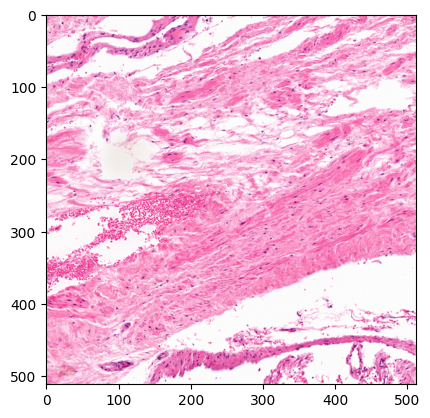

In [12]:
image_path = "../../../data/UNet_Data_Bigger/103/267_0_tile_False_False_False_False_False.png"

# Open an image file
image = Image.open(image_path)
plt.imshow(image)